# Part 4: Modeling
This notebook follows these steps:
1. Load target values
2. Establish the baseline accuracy acheived by human reviewers
3. Run the best model, dense neural network at 100 epochs
4. Rerun the best model at 50 epochs to avoid overfitting
5. Compare model results to the baseline

**Appendices**
Various versions of the DNN as well as convulation neural networks models are shown in the appendix. All of these models acheived lower performance levels. In earlier iterations, modeling with sex_emotion as the target was also tried, but resulted in lower accuracy and was not included in the final notebook.

*This notebook should be run using the deeplearning.yml environment.*

### Loading libraries

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import glob
import os
import pickle
import wave

import json # for saving history files
import time
from datetime import datetime

In [5]:
# Specific neural network models & layer types
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

In [6]:
import random

def set_random_seed(seed):
    
    '''Random seeds for reproducability'''
    
    random.seed(seed)
    tf.random.set_seed(seed)

In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

### Defining functions for later use
- The function plot_history() plots the history of loss and accuracy over the epochs of the tensor flow modle fitting process.
- The function confusion() creates a confusion matrix based on predicted and actual values.

In [8]:
def plot_history(history_input,title=None):
    '''
    a function that takes the history from a tensorflow model fitting and returns
    plots showing loss and accuracy by epoch
    
    INPUT:
    -----
    history_input - a tensorflow model fitting history object
    title - a string that will be the title of the subplots
    
    RETURN:
    -------
    returns nothing, but displays plots
    
    '''
    max_val = max(history_input.history['val_accuracy'])
    if title == None:
        title = 'Best validation accuracy is {:.2f}%'.format(100*max_val)
    plt.subplots(2,1,figsize=(10,5))
    plt.suptitle(title,fontsize=16)
    
    plt.subplot(2,1,1)
    plt.plot(history_input.history['loss'])
    plt.plot(history_input.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'])

    plt.subplot(2,1,2)
    plt.plot(history_input.history['accuracy'],label='Train')
    plt.plot(history_input.history['val_accuracy'],label='Validation')
    plt.title('Model Accuracy')
    plt.hlines(max_val,xmin=0,xmax=len(history_input.history['val_accuracy'])-1,label='Max validation accuracy',linestyles='--',color='green')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()
    
    return None

In [9]:
def confusion(y_true,y_predicted,title='Confusion Matrix'):
    '''
    Generates a confusion matrix for given set of y_true and y_predicted values
    
    INPUT:
    ------
    y_true - a series of integers indicating classes; these are the true class values
    y_predicted - a series of integers indicating the predicted class values
        
        y_true and y_predicted should have the same length
        integers indicating classes should be as defined in the target_var_dict['y_emotion']
    
    title - a string to be the title; default value is 'Confusion Matrix'
    
    Return:
    -------
    returns none, displays a Confusion matrix
    
    '''
    
    cm = confusion_matrix(y_true,y_predicted,normalize='true')

    ax = plt.subplot()
    sns.heatmap(cm, annot=True, ax=ax, cmap='gray')
    # labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels') 
    ax.set_title(title) 
    ax.xaxis.set_ticklabels(target_var_dict['y_emotion'].values())
    ax.yaxis.set_ticklabels(target_var_dict['y_emotion'].values()) 

### Loading y_train,  y_test and the interpretation dictionary

In [10]:
# Load in the y data
y_train = pd.read_pickle('extracted_features_for_modeling/y_train_pickled.pkl')
y_test = pd.read_pickle('extracted_features_for_modeling/y_test_pickled.pkl')

In [11]:
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

y_train shape: (6792, 7)
y_test shape: (1699, 7)


The shapes are correct. Let's load the interpretation dictionary.

In [12]:
with open('dataframes_and_dictionaries/target_var_dict.pkl', 'rb') as handle:
    target_var_dict = pickle.load(handle)

In [13]:
# check the keys
target_var_dict.keys()

dict_keys(['y_emotion', 'y_sex', 'y_sex_emotion'])

In [14]:
# check the coding for emotion
target_var_dict['y_emotion']

{0: 'NEU', 1: 'HAP', 2: 'SAD', 3: 'ANG', 4: 'DIS', 5: 'FEA'}

The dictionary is properly loaded and the encoding is correct.

# (A) Establish a baseline for assessing accuracy

Given our observations are evenly distrubted across our six emotions, the naive baseline is (1/6) or 16.67%.

However, the Crema-D study ran an assessment with 2,443 reviewers, each performing a blind classification of 30 audio files. Crema-D makes up close to 90% of our observations, so human assessment will provide a well-grounded point of comparison against which to judge our model.

We will examine the human performance, then discuss some nuances that make this classification difficult.

### Read in the reviewer data
We read in the reviewer responses and focus only on the following columns:
- reviewer, which is read in as 'localid'
- 'queryType', which idetnfies whether the review was related to audio-only, video-only, or audio-video; we will only examine audio only, which is identified with a valye of 1
- 'prediction', which is read in as 'respEmo'; this is the emotion that the reviewer identified
- 'actual', which is read in as 'dispEmo'; this identifies the emotion that the actor intended to express

In [15]:
df_baseline = pd.read_csv('raw_data/crema_d_finishedresponses.csv',low_memory=False)

In [16]:
df_baseline.shape

(219688, 17)

In [17]:
df_baseline.head()

,Unnamed: 0,localid,pos,ans,ttr,queryType,numTries,clipNum,questNum,subType,clipName,sessionNums,respEmo,respLevel,dispEmo,dispVal,dispLevel
0,13,SSI_1090000584,13,N_58,14516,1,0,768,1,4,1010_MTI_SAD_XX,1,N,58,S,50.0,X
1,17,SSI_1090000584,17,H_39,6977,1,0,2981,2,4,1037_IWL_HAP_XX,1,H,39,H,50.0,X
2,21,SSI_1090000584,21,S_79,5760,1,0,1736,3,4,1022_IWW_FEA_XX,1,S,79,F,50.0,X
3,25,SSI_1090000584,25,F_40,10512,1,0,5471,4,4,1067_WSI_HAP_XX,1,F,40,H,50.0,X
4,29,SSI_1090000584,29,N_88,6911,1,0,21,5,4,1001_TIE_FEA_XX,1,N,88,F,50.0,X


**Drop observations that are not audio-only**

We filter out all obervations that do not have a 'queryType' of 1

In [18]:
# check how many observations there are for each query type
df_baseline['queryType'].value_counts()

1    73254
3    73242
2    73192
Name: queryType, dtype: int64

Approximately 1/3 of reviews are audio only. We remove the remainder.

In [19]:
# filter down to only 'queryType' =1
df_baseline = df_baseline[(df_baseline['queryType'] == 1)]
df_baseline.shape

(73254, 17)

**Drop columns that we will not be using**

We will include 'queryType in our drop since we no longer need it. We will only retain:
- 'localid'
- 'respEmo'
- 'dispEmo'

In [20]:
#create a list of all columns
cols_to_drop = list(df_baseline.columns)

# remove the columns names that we want to keep
for column in ['localid','respEmo','dispEmo']:
    cols_to_drop.remove(column)

# display the list of columns to be dropped
cols_to_drop

['Unnamed: 0',
 'pos',
 'ans',
 'ttr',
 'queryType',
 'numTries',
 'clipNum',
 'questNum',
 'subType',
 'clipName',
 'sessionNums',
 'respLevel',
 'dispVal',
 'dispLevel']

In [21]:
# drop the columns
df_baseline.drop(columns=cols_to_drop,inplace=True)
# check the shape
df_baseline.shape

(73254, 3)

Now, we just have the three columns that we need. We rename them next.

In [22]:
# check the names of our remaining columns
df_baseline.columns

Index(['localid', 'respEmo', 'dispEmo'], dtype='object')

In [23]:
# rename the columns
df_baseline.columns = ['reviewer','prediction','actual']
# check the new column names
df_baseline.columns

Index(['reviewer', 'prediction', 'actual'], dtype='object')

We replace values in our prediction and actual columns to match the values we are using target columns

In [24]:
# Let's list out th eunique values in our 'prediction' and 'actual' column
set(df_baseline['actual']).union(set(df_baseline['prediction']))

{'A', 'D', 'F', 'H', 'N', 'S'}

In [25]:
# let's look at the values in our dictionary
target_var_dict['y_emotion']

{0: 'NEU', 1: 'HAP', 2: 'SAD', 3: 'ANG', 4: 'DIS', 5: 'FEA'}

In [26]:
# we create a new dictionary for replacing the values in the df_baseline

# initialize a dictionary for df_baseline
baseline_dict = {}

# iterate over the keys in the existing dictionary
for key in target_var_dict['y_emotion'].keys():
    
    # get the first letter of each key's value
    letter = target_var_dict['y_emotion'][key][0]
    
    # add the letter as the key in the dictionary and orignal key as the new value
    baseline_dict[letter] = key

# display the baseline dictionary
baseline_dict

{'N': 0, 'H': 1, 'S': 2, 'A': 3, 'D': 4, 'F': 5}

In [27]:
# replace values in baseline
df_baseline['actual'] = df_baseline['actual'].replace(baseline_dict)
df_baseline['prediction'] = df_baseline['prediction'].replace(baseline_dict)

We now examine how many unique reivewers there are and how many reviews they performed

In [28]:
df_baseline['reviewer'].value_counts()

SSI_1132064474    31
SSI_1090000584    30
SSI_1126583425    30
SSI_1156518355    30
SSI_1116527955    30
                  ..
SSI_1132233840    29
SSI_1158667909    28
SSI_1132078749    28
SSI_1158752334    23
SSI_1159885300    22
Name: reviewer, Length: 2443, dtype: int64

We have 2,443 different reviewers, with the number of observations per reviewer falling between 22 and 31 reviews. We examine the distribution of number of reviews next.

In [29]:
df_baseline['reviewer'].value_counts().value_counts(normalize=True)

30    0.990585
29    0.007368
28    0.000819
31    0.000409
23    0.000409
22    0.000409
Name: reviewer, dtype: float64

**Over 99% of reviewers provided 30 reviews**

At 30 different reviews, we should have a sufficient sample size to robustly assess each reviewer's accuracy. Next, we create a 'correct' column to show whether the correct emtoion was identified by the reviewer.

### The median reviewer acheives an accuracy of 40%

In [30]:
df_baseline['correct'] = (df_baseline['prediction'] == df_baseline['actual']).copy()

In [31]:
print('Overall, mean accuracy across all reviews of all reviewers is {:.2f}%'.format(100*df_baseline['correct'].mean()))

Overall, mean accuracy across all reviews of all reviewers is 39.19%


Next, we examine performance by reviewer.

In [32]:
# calculate the median reviewer accuracy
median_reviewer_accuracy = df_baseline[['reviewer','correct']].groupby('reviewer').mean()['correct'].median()
print('Median reviewer accuracy is {:.2f}%'.format(100*median_reviewer_accuracy))

Median reviewer accuracy is 40.00%


In [33]:
mean_reviewer_accuracy = df_baseline[['reviewer','correct']].groupby('reviewer').mean()['correct'].mean()
print('Mean reviewer accuracy is {:.2f}%'.format(100*mean_reviewer_accuracy))

Mean reviewer accuracy is 39.18%


In [34]:
# describe the distribution of reviewer accuracy
df_baseline[['reviewer','correct']].groupby('reviewer').mean()['correct'].describe()

count    2443.000000
mean        0.391842
std         0.138325
min         0.000000
25%         0.300000
50%         0.400000
75%         0.500000
max         0.866667
Name: correct, dtype: float64

In [35]:
# save the accurayc of the top quartile reviewer threshold
top_quartile = df_baseline[['reviewer','correct']].groupby('reviewer').mean()['correct'].describe()['75%']

The 2nd quartile begins at 30% accuracy and top quartile begins at 50% accuracy.

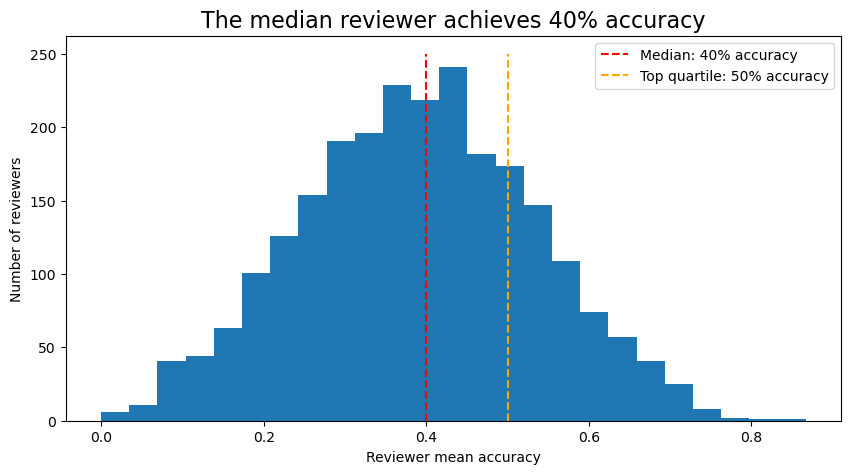

In [36]:
plt.figure(figsize=(10,5))
plt.hist(df_baseline[['reviewer','correct']].groupby('reviewer').mean()['correct'],cumulative=False,bins=25)
plt.vlines(x=median_reviewer_accuracy,ymin=0,ymax=250,label='Median: {:.0f}% accuracy'.format(100*median_reviewer_accuracy),color='red',linestyles='--')
plt.vlines(x=top_quartile,ymin=0,ymax=250,label='Top quartile: {:.0f}% accuracy'.format(100*top_quartile),color='orange',linestyles='--')
plt.xlabel('Reviewer mean accuracy')
plt.ylabel('Number of reviewers')
plt.legend()
plt.title('The median reviewer achieves 40% accuracy',fontsize=16)
plt.show()

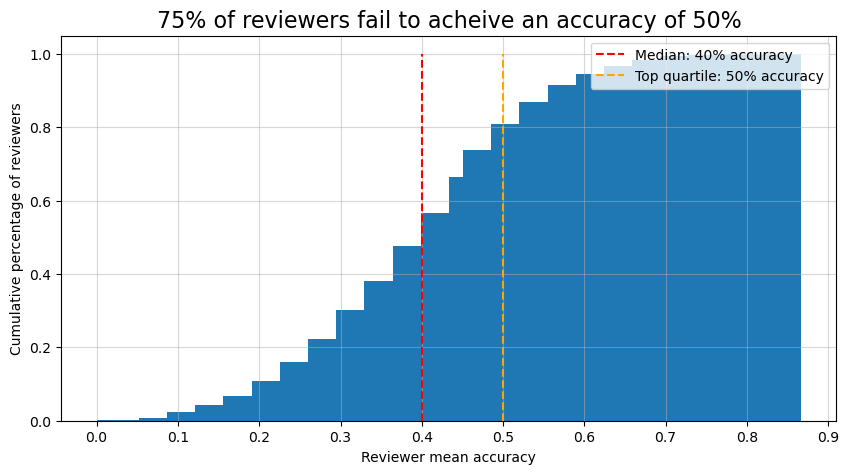

In [37]:
plt.figure(figsize=(10,5))
plt.hist(df_baseline[['reviewer','correct']].groupby('reviewer').mean()['correct'],cumulative=True,density=True,bins=50,histtype='stepfilled')
# add some tickes to show more detail
plt.xticks(np.arange(0,1,.1))
plt.grid(visible=True,alpha=.5)
plt.vlines(x=median_reviewer_accuracy,ymin=0,ymax=1,label='Median: {:.0f}% accuracy'.format(100*median_reviewer_accuracy),color='red',linestyles='--')
plt.vlines(x=top_quartile,ymin=0,ymax=1,label='Top quartile: {:.0f}% accuracy'.format(100*top_quartile),color='orange',linestyles='--')
plt.xlabel('Reviewer mean accuracy')
plt.ylabel('Cumulative percentage of reviewers')
plt.title('75% of reviewers fail to acheive an accuracy of 50%',fontsize=16)
plt.legend()
plt.show()

### Why is accuracy so low?

On the surface, identifying the emotion expressed by a speaker seems like a trivial task for any adult. However, on reflection, most people can probably recall instances just in the last 24 hours when they weren't sure exactly how someone felt. Are they angry or anxious? Sad or just tired?

In fact, classifying observations in this dataset is substantially more challenging for reviewers than classifying emotion in their day to day interactions:

**No prior context for understanding the speaker**
- Often our most frequent and important interactions involve people whom we have met before and with whom we have some prior relationship. Our memory of previous interactions and our understanding of their motivations and reactions give us significant predictive power for identifying emotion in a new segment of speech. Even when we watch a movie or TV show, we are usually listening to an actor about whome we have already collected background information. Content producers often go to great lengths to quickly establish a background story that we can use as context. In this dataset, sentences come with no context.

**No visual data**
- For most of the time our species has existed, the vast majority of communication has happened at close range, where we are able to see the speaker while also listening to them. We rely heavily on this visual data to fully interpret a speaker's meaning and emotion. Crema-D offers another dataset with a video component accompanying the audio. When presented with this dataset, reviewers were able to acheive median accuracy scores near 70%. The absence of accompanying visual data makes identification of emotion more difficult.

**No verbal meaning**
- In day-to-day interactions, we augment our understanding of a speaker's emotion by considering the meaning of the words that were spoken. In this experiment, sentences were explicitly chosen that had no emotional content. However, in regular human-to-human interactions, we interpret use word content to better interpret audio intonation.

Correctly identifying emotion in this dataset is a difficult task for humans. Before we begin modeling, let's:
1. Examine categorical accuracy for each emotion, and
2. examine the confusion matrix for the human reviewers and see if any trends stand out.

In [38]:
# list categorical accuracy by emotion

# create a new dataframe by grouping by the actual emotion class and taking mean the mean
# this mean is actually the recall score in this multiclass environment since the denominator is all actual values for the emotional class
score_df = df_baseline[['actual','correct']].groupby('actual').mean()
# rename the accuracy column
score_df.columns = ['baseline_recall']
# calculate the precision score
score_df['baseline_precision'] = precision_score(df_baseline['actual'],df_baseline['prediction'],average=None)
# calculate the F1 score as the harmonic mena of precision and recall
score_df['baseline_f1'] = (2 * score_df['baseline_precision'] * score_df['baseline_recall']) / (score_df['baseline_precision'] + score_df['baseline_recall'])
# rename the indices with their string names
score_df.index = score_df.index.map(target_var_dict['y_emotion'])
# sort the values
score_df.sort_values(by='baseline_recall',ascending=False,inplace=True)
# display the dataframe
score_df

,baseline_recall,baseline_precision,baseline_f1
actual,,,
NEU,0.753763,0.252357,0.378120
ANG,0.516211,0.626060,0.565854
FEA,0.314187,0.444117,0.368021
HAP,0.283504,0.720367,0.406879
DIS,0.282725,0.367856,0.319721
SAD,0.249479,0.420313,0.313110


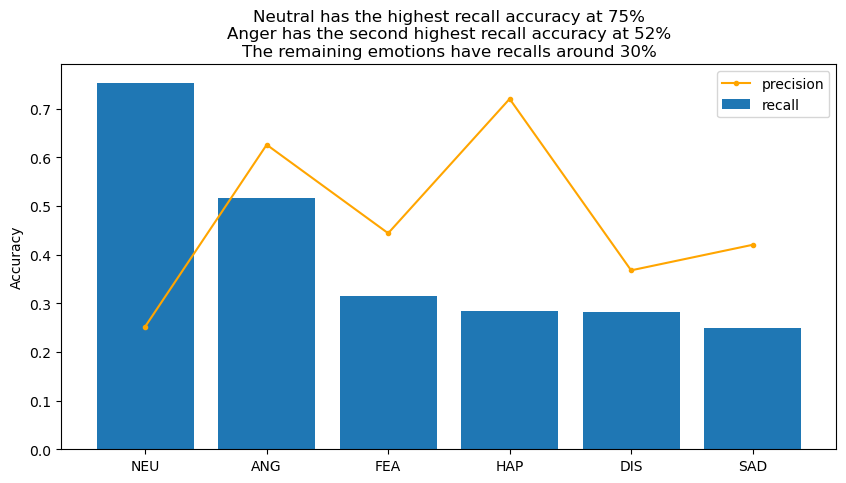

In [39]:
plt.figure(figsize=(10,5))
plt.bar(score_df.index,score_df['baseline_recall'],label='recall')
plt.plot(score_df.index,score_df['baseline_precision'],marker='.',color='orange',label='precision')
plt.ylabel('Accuracy')
plt.title('Neutral has the highest recall accuracy at 75%\nAnger has the second highest recall accuracy at 52%\nThe remaining emotions have recalls around 30%')
plt.legend()
plt.show()

**Neutral is the go-to category when reviewers are unsure of the appropriate classification**

Neutral's high recall score indicates that very few neutral observations are misclassified. However, it's low precision indicates that many non-neutral observations have been incorrectly classified as neutral. Together, this suggests that when reviewers are uncertain, they tend to click neutral. In casting this wide net, they have cuaght many neutral observations but also misclassified many non-neutral observations.

Anger has a high recall and high precision indicating that this emotion is the easiest to classify correctly. If it's anger, people identify it; if it's not anger, people don't mistakenly conclude that it is anger.

Happiness's high precison score indicates that if an observation is happy, reviewers generally correctly identify this. However, the low recall score indicates that reviewers are prone to misidentifying non-happy emotions as happy. "I thought you were happy but you're not."

Sad has the lowest recall score. "You were sad, but didn't realize it."

Let's examine the confusion matrix.

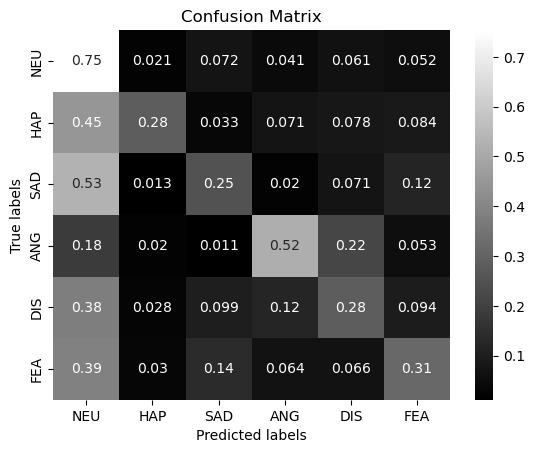

In [40]:
confusion(df_baseline['actual'],df_baseline['prediction'])

**For happy, sad, disgust, and fear, more observations are incorrectly classified as neutral than are correctly classified**

Reviewers are most likely to select teh neutral class for all emotions except anger.

# (B) Dense Neural Network on features averaged over time provides the best fit with a test accuracy of 48.5%
Below is our best fitting model. Additional models (including 1D CNNs) are in the appendix at the end.

### Load in X_train, X_test

In [41]:
# load the data
X_train = np.load('extracted_features_for_modeling/X_train_DNN.npy',allow_pickle=True)
X_test = np.load('extracted_features_for_modeling/X_test_DNN.npy',allow_pickle=True)

# Check out the data
print(f'X_train shape: {X_train.shape}')
print(f'y_train length: {len(y_train)}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test length: {len(y_test)}')

X_train shape: (6792, 186)
y_train length: 6792
X_test shape: (1699, 186)
y_test length: 1699


### Scale the data
We scale the data with a min max scaler because we know many features range between -1 and 1, while other features reach as high as 6000. We use a minmax scaler to preserve the underlying distributions. In earlier iterations, a standard scaler was also tried, but resulted in lower validation accuracies.

In [42]:
# range of x values
print(f'X_train range: {round(X_train.min())} - {round(X_train.max())}')
print(f'X_test range: {round(X_test.min())} - {round(X_test.max())}')

X_train range: -1131 - 6081
X_test range: -589 - 5785


In [43]:
from sklearn.preprocessing import MinMaxScaler
DNN_scaler = MinMaxScaler()
DNN_scaler.fit(X_train)

MinMaxScaler()

In [44]:
X_train_scaled = DNN_scaler.transform(X_train)
X_test_scaled = DNN_scaler.transform(X_test)

In [45]:
# range of x values
print(f'X_train_scaled range: {round(X_train_scaled.min())}-{round(X_train_scaled.max())}')
print(f'X_test_scaled range: {round(X_test_scaled.min())}-{round(X_test_scaled.max())}')

X_train_scaled range: 0-1
X_test_scaled range: 0-4


### First run the Dense neural network with 100 epochs
- First, we run the model with 100 epochs to identify when overfitting begins

#### Architecture

In [46]:
DNN_model = keras.Sequential()

# Add dense layers with dropout
DNN_model.add(Dense(300, activation='relu', input_shape=(186,)))
DNN_model.add(Dropout(0.25))

DNN_model.add(Dense(64, activation='relu', input_shape=(186,)))
DNN_model.add(Dropout(0.25))

DNN_model.add(Dense(6, activation='softmax'))

# Print out a summary of the network
DNN_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 300)               56100     
_________________________________________________________________
dropout (Dropout)            (None, 300)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                19264     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 390       
Total params: 75,754
Trainable params: 75,754
Non-trainable params: 0
_________________________________________________________________


#### Compile and fit

In [47]:
# Compile the model with the desired loss function, optimizer, and metric(s) to track
DNN_model.compile(loss = 'sparse_categorical_crossentropy',
                  optimizer = 'Adam',
                  metrics = ['accuracy'])

In [48]:
%%time
history_DNN_emotion = DNN_model.fit(X_train_scaled, y_train['y_emotion'], epochs=100, verbose=1, validation_split=0.2)

C:\Users\Stonebreaker06\Anaconda3\envs\deeplearning\lib\site-packages\tensorflow\python\keras\engine\data_adapter.py:1402: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


Epoch 1/100
170/170 [==============================] - 1s 4ms/step - loss: 1.6912 - accuracy: 0.2770 - val_loss: 1.5836 - val_accuracy: 0.3576
Epoch 2/100
170/170 [==============================] - 0s 2ms/step - loss: 1.5706 - accuracy: 0.3363 - val_loss: 1.5084 - val_accuracy: 0.3738
Epoch 3/100
170/170 [==============================] - 0s 2ms/step - loss: 1.5249 - accuracy: 0.3652 - val_loss: 1.4815 - val_accuracy: 0.4054
Epoch 4/100
170/170 [==============================] - 0s 3ms/step - loss: 1.5004 - accuracy: 0.3839 - val_loss: 1.4564 - val_accuracy: 0.4010
Epoch 5/100
170/170 [==============================] - 0s 2ms/step - loss: 1.4812 - accuracy: 0.3990 - val_loss: 1.4704 - val_accuracy: 0.3878
Epoch 6/100
170/170 [==============================] - 0s 2ms/step - loss: 1.4544 - accuracy: 0.4097 - val_loss: 1.4279 - val_accuracy: 0.4415
Epoch 7/100
170/170 [==============================] - 0s 2ms/step - loss: 1.4355 - accuracy: 0.4110 - val_loss: 1.4009 - val_accuracy: 0.4415

Epoch 58/100
170/170 [==============================] - 0s 2ms/step - loss: 1.1518 - accuracy: 0.5483 - val_loss: 1.2692 - val_accuracy: 0.4864
Epoch 59/100
170/170 [==============================] - 0s 2ms/step - loss: 1.1502 - accuracy: 0.5487 - val_loss: 1.2854 - val_accuracy: 0.5026
Epoch 60/100
170/170 [==============================] - 1s 3ms/step - loss: 1.1432 - accuracy: 0.5527 - val_loss: 1.3525 - val_accuracy: 0.4614
Epoch 61/100
170/170 [==============================] - 0s 2ms/step - loss: 1.1462 - accuracy: 0.5452 - val_loss: 1.2701 - val_accuracy: 0.5011
Epoch 62/100
170/170 [==============================] - 0s 2ms/step - loss: 1.1345 - accuracy: 0.5544 - val_loss: 1.2914 - val_accuracy: 0.4930
Epoch 63/100
170/170 [==============================] - 0s 2ms/step - loss: 1.1342 - accuracy: 0.5535 - val_loss: 1.2937 - val_accuracy: 0.5048
Epoch 64/100
170/170 [==============================] - 0s 2ms/step - loss: 1.1248 - accuracy: 0.5623 - val_loss: 1.2769 - val_accuracy:

#### Scores

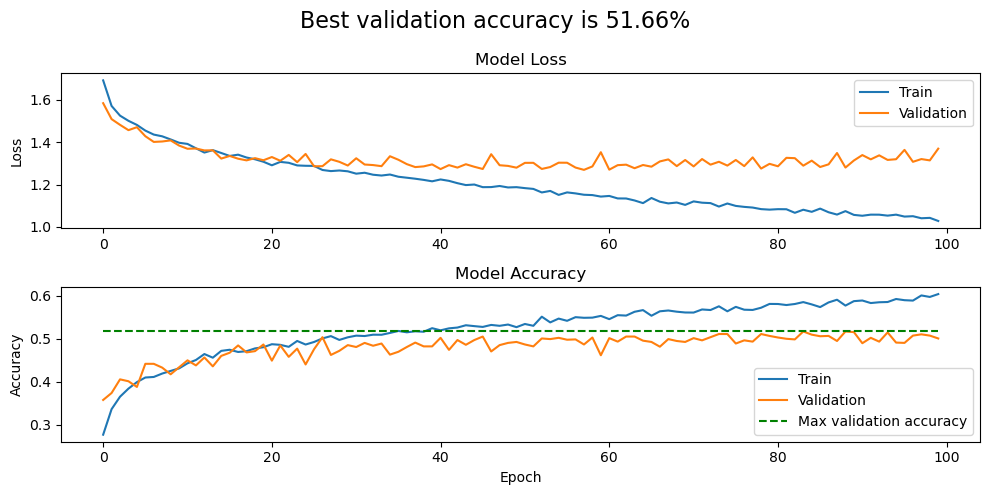

In [49]:
plot_history(history_DNN_emotion)

**Observations**
By the 100th epoch, the model appears to be overfitting. By the 50th epoch, the model appears to have already approached its best validation accuracy. We will build our final model with 50 epochs.

### Run the final Dense neural network with 50 epochs

#### Architecture

In [50]:
DNN_model = keras.Sequential()

# re-initialize the model so that it starts fresh rather than picking up on the 101st epoch

# Add dense layers with drop out
DNN_model.add(Dense(300, activation='relu', input_shape=(186,)))
DNN_model.add(Dropout(0.25))

DNN_model.add(Dense(64, activation='relu', input_shape=(186,)))
DNN_model.add(Dropout(0.25))

DNN_model.add(Dense(6, activation='softmax'))

# Print out a summary of the network
DNN_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 300)               56100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                19264     
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 390       
Total params: 75,754
Trainable params: 75,754
Non-trainable params: 0
_________________________________________________________________


#### Compile and fit

In [51]:
# Compile the model with the desired loss function, optimizer, and metric(s) to track
DNN_model.compile(loss = 'sparse_categorical_crossentropy',
                  optimizer = 'Adam',
                  metrics = ['accuracy'])

In [52]:
%%time
history_DNN_emotion = DNN_model.fit(X_train_scaled, y_train['y_emotion'], epochs=50, verbose=1, validation_split=0.2)

Epoch 1/50


C:\Users\Stonebreaker06\Anaconda3\envs\deeplearning\lib\site-packages\tensorflow\python\keras\engine\data_adapter.py:1402: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


170/170 [==============================] - 1s 4ms/step - loss: 1.6717 - accuracy: 0.2671 - val_loss: 1.5802 - val_accuracy: 0.3164
Epoch 2/50
170/170 [==============================] - 1s 3ms/step - loss: 1.5663 - accuracy: 0.3363 - val_loss: 1.5273 - val_accuracy: 0.3377
Epoch 3/50
170/170 [==============================] - 0s 2ms/step - loss: 1.5354 - accuracy: 0.3539 - val_loss: 1.5041 - val_accuracy: 0.3495
Epoch 4/50
170/170 [==============================] - 0s 3ms/step - loss: 1.5084 - accuracy: 0.3720 - val_loss: 1.4641 - val_accuracy: 0.3996
Epoch 5/50
170/170 [==============================] - 1s 4ms/step - loss: 1.4826 - accuracy: 0.3937 - val_loss: 1.4636 - val_accuracy: 0.4172
Epoch 6/50
170/170 [==============================] - 0s 3ms/step - loss: 1.4628 - accuracy: 0.4005 - val_loss: 1.4289 - val_accuracy: 0.4253
Epoch 7/50
170/170 [==============================] - 0s 3ms/step - loss: 1.4402 - accuracy: 0.4084 - val_loss: 1.4152 - val_accuracy: 0.4297
Epoch 8/50
170/17

#### Scores

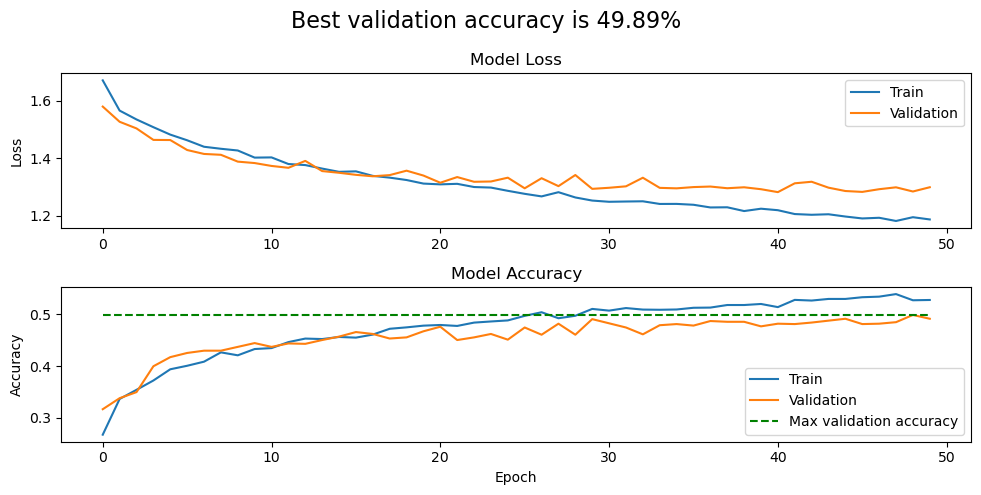

In [53]:
plot_history(history_DNN_emotion)

In [54]:
score, acc = DNN_model.evaluate(X_test_scaled, y_test['y_emotion'])
print('Test accuracy is {:.2f}%'.format(100*acc))

54/54 [==============================] - 0s 1ms/step - loss: 1.2761 - accuracy: 0.5021
Test accuracy is 50.21%


**Our best model acheives a validation accuracy of 48.5%**

#### Save the model

In [56]:
DNN_model.save('models/best_SER_model', save_format='tf')

INFO:tensorflow:Assets written to: models/best_SER_model\assets


**Let's compare this test accuracy to our baseline**

In [57]:
# compile reviwer median and top quartile accuracy along with the model's test accuracy
scores = pd.Series([median_reviewer_accuracy,acc,top_quartile])
scores.index = ['Median reviewer accuracy','Model test accuracy','Top quartile reviewer accuracy']

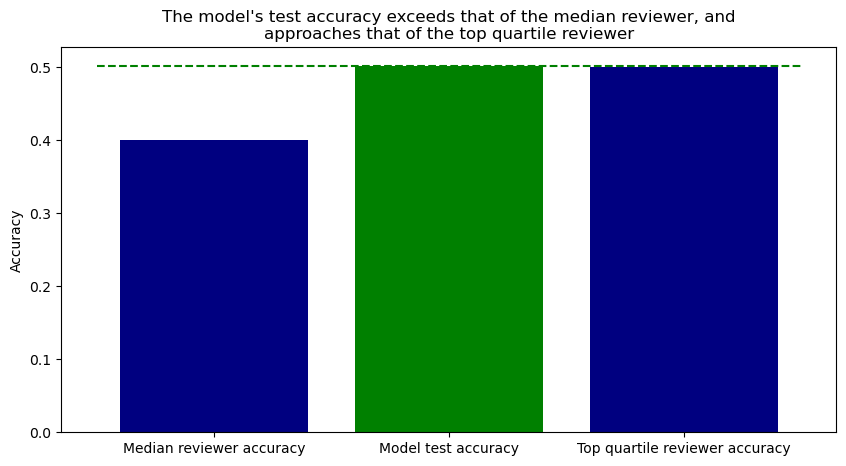

In [58]:
plt.figure(figsize=(10,5))
plt.bar(scores.index, scores, color=['navy','green','navy'])
plt.hlines(y=acc,xmin=-.5,xmax=2.5,color='green',linestyle='--',label='Model test accuracy')
plt.ylabel('Accuracy')
plt.title('The model\'s test accuracy exceeds that of the median reviewer, and\napproaches that of the top quartile reviewer')
plt.show()

Let's examine how the precision and recall compare by category.

In [59]:
# get the model predictions
y_pred = np.argmax(DNN_model.predict(X_test_scaled), axis=-1)
# calculate the precision score as a pandas series
prec_s = pd.Series(precision_score(y_test['y_emotion'],y_pred,average=None))
# set the index with teh emotion names
prec_s.index = target_var_dict['y_emotion'].values()
# calculate the recall score as a pandas series
recal_s = pd.Series(recall_score(y_test['y_emotion'],y_pred,average=None))
# set the index with teh emotion names
recal_s.index = target_var_dict['y_emotion'].values()
# add teh precision and recall scores to the score_df
score_df['model_recall'] = recal_s
score_df['model_precision'] = prec_s
# calculate the F1 score for the model
score_df['model_f1'] = (2 * score_df['model_precision'] * score_df['model_recall']) / (score_df['model_precision'] + score_df['model_recall'])
# display the scores for the baseline and the model
score_df

,baseline_recall,baseline_precision,baseline_f1,model_recall,model_precision,model_f1
actual,,,,,,
NEU,0.753763,0.252357,0.378120,0.392405,0.462687,0.424658
ANG,0.516211,0.626060,0.565854,0.729452,0.600000,0.658423
FEA,0.314187,0.444117,0.368021,0.400685,0.522321,0.453488
HAP,0.283504,0.720367,0.406879,0.472603,0.452459,0.462312
DIS,0.282725,0.367856,0.319721,0.399317,0.423913,0.411248
SAD,0.249479,0.420313,0.313110,0.597270,0.517751,0.554675


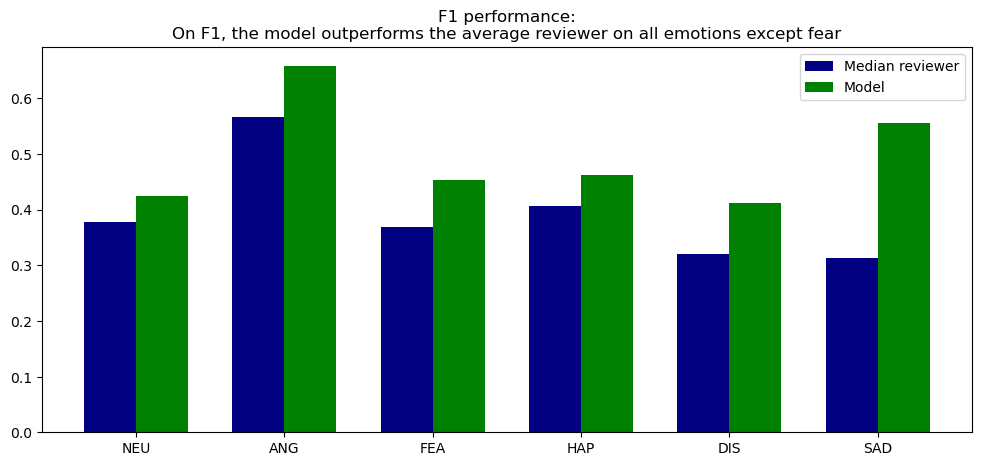

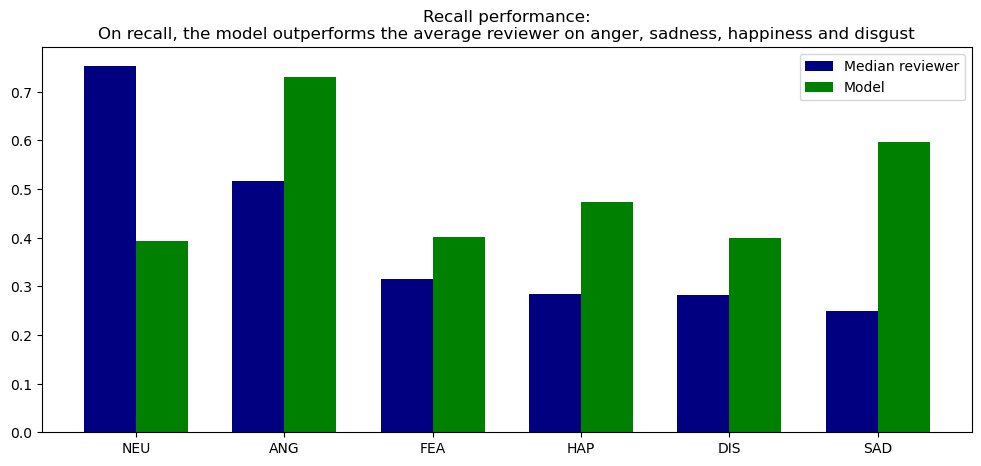

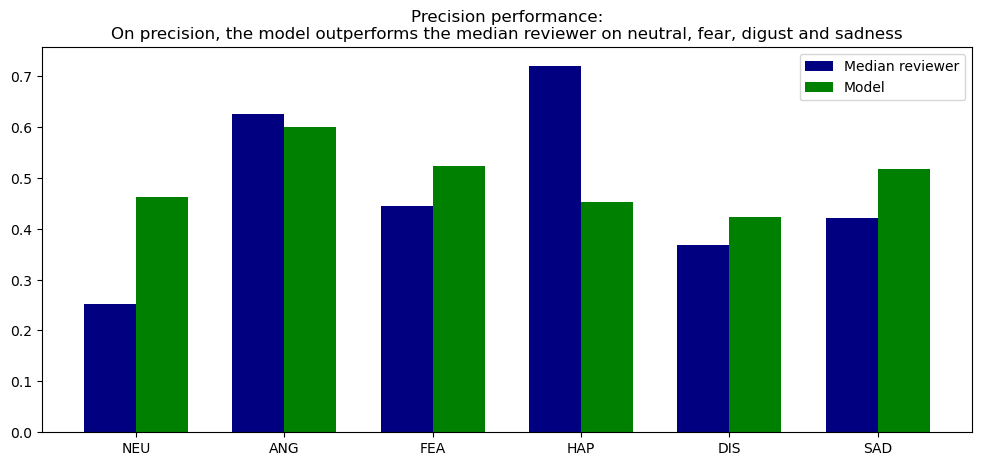

In [60]:
index = np.arange(6)
bar_width = 0.35

fig, ax = plt.subplots(figsize=(12,5))
baseline = ax.bar(index, score_df['baseline_f1'], bar_width,
                label="Median reviewer",color='navy')

model = ax.bar(index+bar_width, score_df['model_f1'],
                 bar_width, label="Model",color='green')


ax.set_title('F1 performance:\nOn F1, the model outperforms the average reviewer on all emotions except fear')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(score_df.index)
ax.legend()

plt.show()

fig, ax = plt.subplots(figsize=(12,5))
baseline = ax.bar(index, score_df['baseline_recall'], bar_width,
                label="Median reviewer",color='navy')

model = ax.bar(index+bar_width, score_df['model_recall'],
                 bar_width, label="Model",color='green')


ax.set_title('Recall performance:\nOn recall, the model outperforms the average reviewer on anger, sadness, happiness and disgust')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(score_df.index)
ax.legend()

plt.show()

fig, ax = plt.subplots(figsize=(12,5))
baseline = ax.bar(index, score_df['baseline_precision'], bar_width,
                label="Median reviewer",color='navy')

model = ax.bar(index+bar_width, score_df['model_precision'],
                 bar_width, label="Model",color='green')


ax.set_title('Precision performance:\nOn precision, the model outperforms the median reviewer on neutral, fear, digust and sadness')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(score_df.index)
ax.legend()

plt.show()

**Observations**

The model is much less-heavy-handed with the neutral classification. It is also clearly better at distinguishing fear and disgust from the other emotions.

**Neutral**
- Although lower than that of the average human reviewer, the model's recall is still high indicating that many neutral observations are being correctly classified.
- The model's higher precision score means that fewer non-neutral observations are being classified as non-neutral. This is also evident in the leftmost column of the model's confusion matrix; we see far fewer non-neutral observations being classified as neutral.
- Overall, the model has been less heavy-handed than reviewers in applying the neutral label.

**Anger**
- The model's high recall score relative to baseline indicates that it is even better at catching angry observations than the human reviewers. This emotion has the model's highest recall score.
- Precision is only slightly lower, so there is only a very small cost of mis-classifying additional non-angry observations as angry.
- Overall, the model performs better on classifying angry.

**Fear**
- Interestingly, the model's recall score is lower for fear than that of the reviewers. It is missing some of the fear observations.
- Correspondingly, the model's precision score has picked up, meaning that fewer non-fear observations are misclassified as fear.

**Happy**
- The model has higher recall and lower precision, meaning that it is correctly identifying more happy observations but also mistaking non-happy observations for happy.
- This can be observed in the second column from the left on the confusion matrices.

**Disgust and Sadness**
- For both of these, the model has improved on both the recall score and precision score.
- It is correctly identifying these observations more often.
- It less freqeuntly misclassifying observations as disgust or sadness

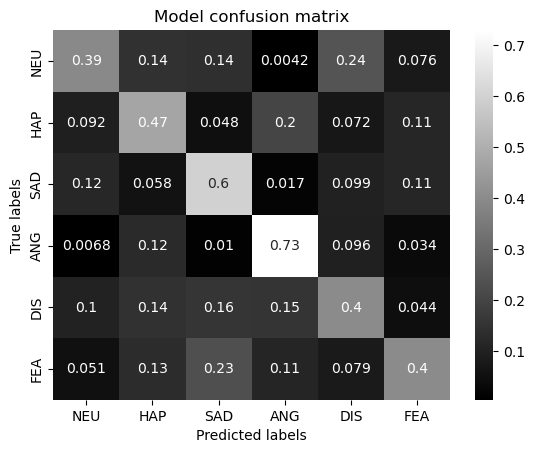

In [61]:
confusion(y_test['y_emotion'],y_pred, title='Model confusion matrix')

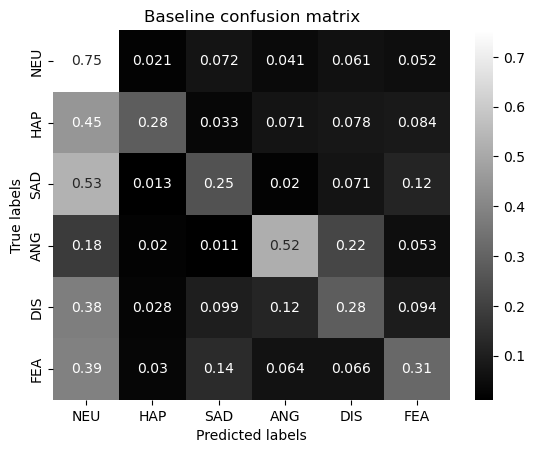

In [62]:
confusion(df_baseline['actual'],df_baseline['prediction'],title='Baseline confusion matrix')

# (C) Appendix: Additional dense neural network models
- Below are several dense neural network architectures that were tried but slightly underperformed the selected model

### DNN v2

#### Architecture

In [63]:
DNN_model2 = keras.Sequential()

# Add dense layers
DNN_model2.add(Dense(300, activation='relu', input_shape=(186,)))
DNN_model2.add(Dropout(0.35))

DNN_model2.add(Dense(150, activation='relu', input_shape=(186,)))
DNN_model2.add(Dropout(0.35))

DNN_model2.add(Dense(6, activation='softmax'))

# Print out a summary of the network
DNN_model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 300)               56100     
_________________________________________________________________
dropout_4 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 150)               45150     
_________________________________________________________________
dropout_5 (Dropout)          (None, 150)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 6)                 906       
Total params: 102,156
Trainable params: 102,156
Non-trainable params: 0
_________________________________________________________________


#### Compile and fit

In [64]:
# Compile the model with the desired loss function, optimizer, and metric(s) to track
DNN_model2.compile(loss = 'sparse_categorical_crossentropy',
                  optimizer = 'Adam',
                  metrics = ['accuracy'])

In [65]:
%%time
history_DNN2 = DNN_model2.fit(X_train_scaled, y_train['y_emotion'], epochs=100, verbose=1, validation_split=0.2)

Epoch 1/100


C:\Users\Stonebreaker06\Anaconda3\envs\deeplearning\lib\site-packages\tensorflow\python\keras\engine\data_adapter.py:1402: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


170/170 [==============================] - 1s 4ms/step - loss: 1.6723 - accuracy: 0.2754 - val_loss: 1.5790 - val_accuracy: 0.3238
Epoch 2/100
170/170 [==============================] - ETA: 0s - loss: 1.5678 - accuracy: 0.34 - 0s 2ms/step - loss: 1.5677 - accuracy: 0.3401 - val_loss: 1.5274 - val_accuracy: 0.3775
Epoch 3/100
170/170 [==============================] - 0s 3ms/step - loss: 1.5319 - accuracy: 0.3580 - val_loss: 1.4951 - val_accuracy: 0.3937
Epoch 4/100
170/170 [==============================] - 1s 4ms/step - loss: 1.5085 - accuracy: 0.3711 - val_loss: 1.4569 - val_accuracy: 0.4113
Epoch 5/100
170/170 [==============================] - 1s 3ms/step - loss: 1.4844 - accuracy: 0.3906 - val_loss: 1.4497 - val_accuracy: 0.4099
Epoch 6/100
170/170 [==============================] - 1s 3ms/step - loss: 1.4682 - accuracy: 0.3981 - val_loss: 1.4301 - val_accuracy: 0.4165
Epoch 7/100
170/170 [==============================] - 1s 3ms/step - loss: 1.4537 - accuracy: 0.4007 - val_loss:

Epoch 58/100
170/170 [==============================] - 0s 2ms/step - loss: 1.1990 - accuracy: 0.5253 - val_loss: 1.2892 - val_accuracy: 0.4945
Epoch 59/100
170/170 [==============================] - 0s 2ms/step - loss: 1.1756 - accuracy: 0.5327 - val_loss: 1.3158 - val_accuracy: 0.4731
Epoch 60/100
170/170 [==============================] - 0s 2ms/step - loss: 1.1870 - accuracy: 0.5244 - val_loss: 1.3129 - val_accuracy: 0.4805
Epoch 61/100
170/170 [==============================] - 0s 2ms/step - loss: 1.1869 - accuracy: 0.5253 - val_loss: 1.2965 - val_accuracy: 0.4923
Epoch 62/100
170/170 [==============================] - 0s 2ms/step - loss: 1.1774 - accuracy: 0.5275 - val_loss: 1.3031 - val_accuracy: 0.4901
Epoch 63/100
170/170 [==============================] - 0s 3ms/step - loss: 1.1824 - accuracy: 0.5299 - val_loss: 1.2984 - val_accuracy: 0.4864
Epoch 64/100
170/170 [==============================] - 0s 3ms/step - loss: 1.1624 - accuracy: 0.5373 - val_loss: 1.2918 - val_accuracy:

#### Scores

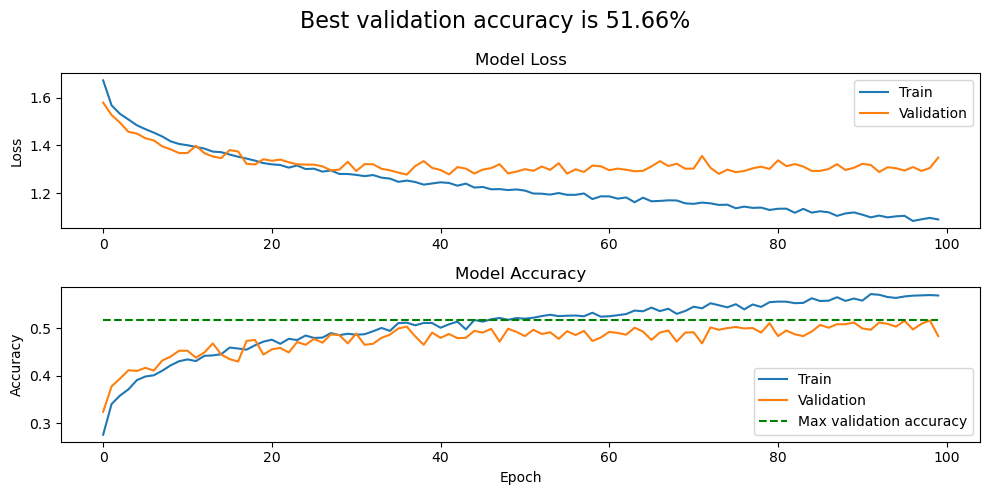

In [66]:
plot_history(history_DNN2)

In [67]:
score, acc = DNN_model2.evaluate(X_test_scaled, y_test['y_emotion'])
print('Test accuracy is {:.2f}%'.format(100*acc))

54/54 [==============================] - 0s 1ms/step - loss: 1.3518 - accuracy: 0.4862
Test accuracy is 48.62%


Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


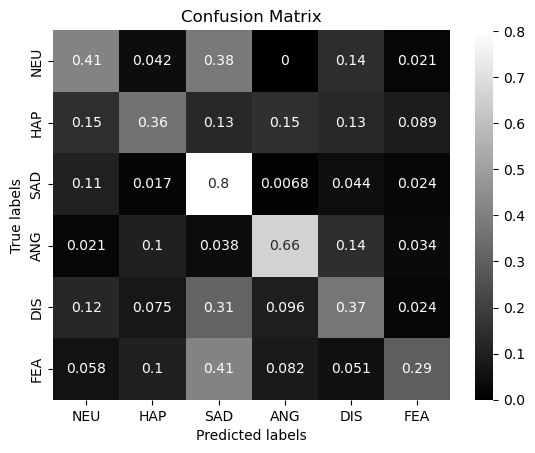

In [68]:
y_pred = DNN_model2.predict_classes(X_test_scaled)
confusion(y_test['y_emotion'],y_pred)

This model performs very similar to the selected model. However, it requires about 1/3 more parameters with little or no additional accuracy.

# (D) Appendix: 1D Convolutional Neural Network with 22kHz sample rate
- We also modeled using a CNN on raw audio sampled at 22kHz (the standard rate we used throughout EDA.

### Load in X_train, X_test

In [69]:
# load the data
X_train_1D_CNN = np.load('extracted_features_for_modeling/X_train_1D_CNN.npy',allow_pickle=True)
X_test_1D_CNN = np.load('extracted_features_for_modeling/X_test_1D_CNN.npy',allow_pickle=True)

# Check out the data
print(f'X_train_1D_CNN shape: {X_train_1D_CNN.shape}')
print(f'y_train length: {len(y_train)}')
print(f'X_test_1D_CNN shape: {X_test_1D_CNN.shape}')
print(f'y_test length: {len(y_test)}')

X_train_1D_CNN shape: (6792, 44100)
y_train length: 6792
X_test_1D_CNN shape: (1699, 44100)
y_test length: 1699


### Scale the data - we do not scale the data
We do not scale since the audio data is already a single feature on the same scale

In [70]:
# range of x values
print(f'X_train_1D_CNN range: {X_train_1D_CNN.min()}-{X_train_1D_CNN.max()}')
print(f'X_test_1D_CNN range: {X_test_1D_CNN.min()}-{X_test_1D_CNN.max()}')

X_train_1D_CNN range: -1.2074036598205566-1.196447491645813
X_test_1D_CNN range: -1.2406889200210571-1.1955008506774902


### Reshape the data

In [71]:

print('Before reshaping:')
print(f'X_train_1D_CNN shape: {X_train_1D_CNN.shape}')
print(f'X_test_1D_CNN shape: {X_test_1D_CNN.shape}\n')

# Reshape for Keras model types
X_train_1D_CNN = X_train_1D_CNN.reshape(X_train_1D_CNN.shape[0], X_train_1D_CNN.shape[1], 1)
X_test_1D_CNN = X_test_1D_CNN.reshape(X_test_1D_CNN.shape[0], X_train_1D_CNN.shape[1], 1)

print('After reshaping:')
print(f'X_train_1D_CNN shape: {X_train_1D_CNN.shape}')
print(f'X_test_1D_CNN shape: {X_test_1D_CNN.shape}')

Before reshaping:
X_train_1D_CNN shape: (6792, 44100)
X_test_1D_CNN shape: (1699, 44100)

After reshaping:
X_train_1D_CNN shape: (6792, 44100, 1)
X_test_1D_CNN shape: (1699, 44100, 1)


### 1D CNN v1 - two convolutions
- First
 - kernel_size = 11
 - strides = 10
- Second
 - kernel_size = 50
 - strides = 3

#### Architecture

In [72]:
CNN1d_model = Sequential()

# Create simple CNN model architecture with Pooling for dimensionality reduction 
# and Dropout to reduce overfitting
CNN1d_model.add(Conv1D(30, strides=10, kernel_size=11, activation = 'relu', input_shape = (44100,1)))
CNN1d_model.add(MaxPooling1D(pool_size=2))
CNN1d_model.add(Dropout(0.25))

CNN1d_model.add(Conv1D(30, strides=3, kernel_size=50, activation = 'relu'))
CNN1d_model.add(MaxPooling1D(pool_size=2))
CNN1d_model.add(Dropout(0.25))

# Flatten the output of our convolutional layers
CNN1d_model.add(Flatten())

# Add dense layers
CNN1d_model.add(Dense(64, activation='relu'))
CNN1d_model.add(Dense(32, activation='relu'))
CNN1d_model.add(Dense(6, activation='softmax'))

# Print out a summary of the network
CNN1d_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 4409, 30)          360       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 2204, 30)          0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 2204, 30)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 719, 30)           45030     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 359, 30)           0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 359, 30)           0         
_________________________________________________________________
flatten (Flatten)            (None, 10770)            

#### Compile & fit

In [73]:
# Compile the model with the desired loss function, optimizer, and metric(s) to track
CNN1d_model.compile(loss = 'sparse_categorical_crossentropy',
                  optimizer = 'Adam',
                  metrics = ['accuracy'])

In [74]:
%%time
history_CNN1d = CNN1d_model.fit(X_train_1D_CNN, y_train['y_emotion'], epochs=10, verbose=1, validation_split=0.2)

Epoch 1/10


C:\Users\Stonebreaker06\Anaconda3\envs\deeplearning\lib\site-packages\tensorflow\python\keras\engine\data_adapter.py:1402: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


170/170 [==============================] - 41s 243ms/step - loss: 1.5997 - accuracy: 0.3184 - val_loss: 1.4884 - val_accuracy: 0.3701
Epoch 2/10
170/170 [==============================] - 41s 241ms/step - loss: 1.4857 - accuracy: 0.3965 - val_loss: 1.4645 - val_accuracy: 0.3951
Epoch 3/10
170/170 [==============================] - 46s 272ms/step - loss: 1.4620 - accuracy: 0.4014 - val_loss: 1.4627 - val_accuracy: 0.3900
Epoch 4/10
170/170 [==============================] - 50s 292ms/step - loss: 1.4306 - accuracy: 0.4110 - val_loss: 1.4550 - val_accuracy: 0.4165
Epoch 5/10
170/170 [==============================] - 47s 276ms/step - loss: 1.4077 - accuracy: 0.4335 - val_loss: 1.4396 - val_accuracy: 0.4113
Epoch 6/10
170/170 [==============================] - 46s 268ms/step - loss: 1.3682 - accuracy: 0.4454 - val_loss: 1.4207 - val_accuracy: 0.4349
Epoch 7/10
170/170 [==============================] - 47s 278ms/step - loss: 1.3189 - accuracy: 0.4780 - val_loss: 1.4424 - val_accuracy: 0.4

#### Scores

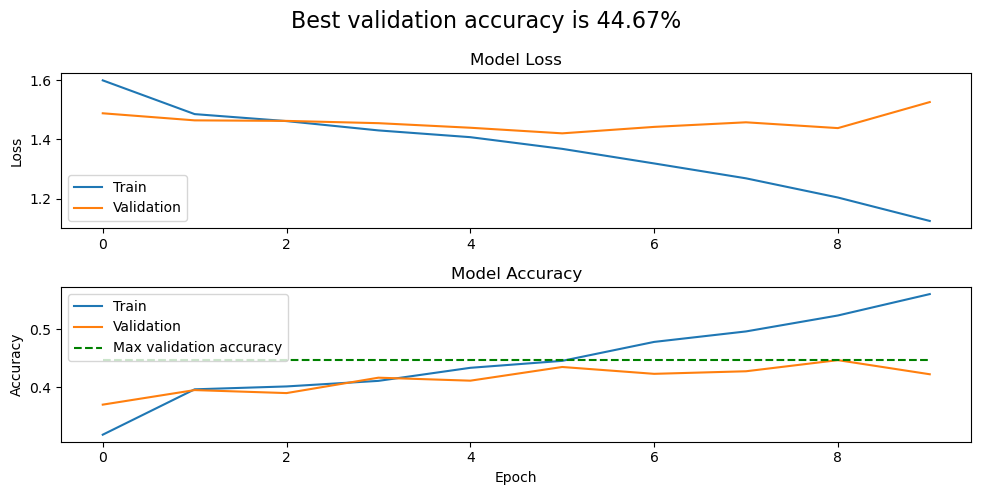

In [75]:
plot_history(history_CNN1d)

### 1D CNN v2 - two convolutions
- First
 - kernel_size = 101
 - strides = 10
- Second
 - kernel_size = 50
 - strides = 3

#### Architecture

In [76]:
CNN1d_model = Sequential()

# Create simple CNN model architecture with Pooling for dimensionality reduction 
# and Dropout to reduce overfitting
CNN1d_model.add(Conv1D(30, strides=10, kernel_size=101, activation = 'relu', input_shape = (44100,1)))
CNN1d_model.add(MaxPooling1D(pool_size=2))
CNN1d_model.add(Dropout(0.25))

CNN1d_model.add(Conv1D(30, strides=3, kernel_size=50, activation = 'relu'))
CNN1d_model.add(MaxPooling1D(pool_size=2))
CNN1d_model.add(Dropout(0.25))

# Flatten the output of our convolutional layers
CNN1d_model.add(Flatten())

# Add dense layers
CNN1d_model.add(Dense(64, activation='relu'))
CNN1d_model.add(Dense(32, activation='relu'))
CNN1d_model.add(Dense(6, activation='softmax'))

# Print out a summary of the network
CNN1d_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 4400, 30)          3060      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 2200, 30)          0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 2200, 30)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 717, 30)           45030     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 358, 30)           0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 358, 30)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 10740)            

#### Compile & fit

In [77]:
# Compile the model with the desired loss function, optimizer, and metric(s) to track
CNN1d_model.compile(loss = 'sparse_categorical_crossentropy',
                  optimizer = 'Adam',
                  metrics = ['accuracy'])

In [78]:
%%time
history_CNN1d = CNN1d_model.fit(X_train_1D_CNN, y_train['y_emotion'], epochs=10, verbose=1, validation_split=0.2)

C:\Users\Stonebreaker06\Anaconda3\envs\deeplearning\lib\site-packages\tensorflow\python\keras\engine\data_adapter.py:1402: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


Epoch 1/10
170/170 [==============================] - 65s 382ms/step - loss: 1.5683 - accuracy: 0.3366 - val_loss: 1.4824 - val_accuracy: 0.3812
Epoch 2/10
170/170 [==============================] - 72s 426ms/step - loss: 1.4889 - accuracy: 0.3889 - val_loss: 1.4637 - val_accuracy: 0.3848
Epoch 3/10
170/170 [==============================] - 74s 436ms/step - loss: 1.4562 - accuracy: 0.4116 - val_loss: 1.4528 - val_accuracy: 0.4113
Epoch 4/10
170/170 [==============================] - 69s 405ms/step - loss: 1.4254 - accuracy: 0.4230 - val_loss: 1.4424 - val_accuracy: 0.4165
Epoch 5/10
170/170 [==============================] - 66s 387ms/step - loss: 1.3863 - accuracy: 0.4397 - val_loss: 1.4510 - val_accuracy: 0.4165
Epoch 6/10
170/170 [==============================] - 84s 492ms/step - loss: 1.3275 - accuracy: 0.4651 - val_loss: 1.4330 - val_accuracy: 0.4268
Epoch 7/10
170/170 [==============================] - 64s 376ms/step - loss: 1.2617 - accuracy: 0.4959 - val_loss: 1.4307 - val_ac

#### Scores

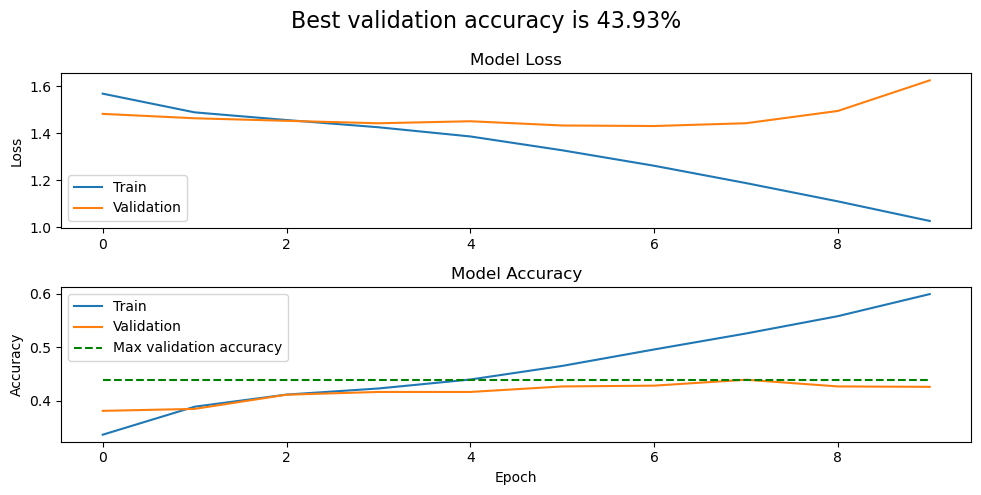

In [79]:
plot_history(history_CNN1d)

### 1D CNN v3 - two convolutions
- First
 - kernel_size = 512
 - strides = 25
- Second
 - kernel_size = 512
 - strides = 25

#### Architecture

In [80]:
CNN1d_model = Sequential()

# Create simple CNN model architecture with Pooling for dimensionality reduction 
# and Dropout to reduce overfitting
CNN1d_model.add(Conv1D(16, kernel_size=512, strides=25, activation = 'relu', input_shape=(44100,1)))
CNN1d_model.add(MaxPooling1D(pool_size=(2,)))

# kernel size is the filter, activation
CNN1d_model.add(Conv1D(32, kernel_size=128, strides=5, activation = 'relu'))
CNN1d_model.add(MaxPooling1D(pool_size=2))
CNN1d_model.add(Dropout(0.25))

CNN1d_model.add(Conv1D(62, kernel_size=31, strides=2, activation = 'relu'))
CNN1d_model.add(MaxPooling1D(pool_size=2))
CNN1d_model.add(Dropout(0.25))

# Flatten the output of our convolutional layers
CNN1d_model.add(Flatten())

# Add dense layers
CNN1d_model.add(Dense(128, activation='relu'))
CNN1d_model.add(Dense(64, activation='relu'))
CNN1d_model.add(Dense(6, activation='softmax'))

# Print out a summary of the network
CNN1d_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 1744, 16)          8208      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 872, 16)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 149, 32)           65568     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 74, 32)            0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 74, 32)            0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 22, 62)            61566     
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 11, 62)           

#### Compile & fit

In [81]:
# Compile the model with the desired loss function, optimizer, and metric(s) to track
CNN1d_model.compile(loss = 'sparse_categorical_crossentropy',
                  optimizer = 'Adam',
                  metrics = ['accuracy'])

In [82]:
%%time
history_CNN1d = CNN1d_model.fit(X_train_1D_CNN, y_train['y_emotion'], epochs=10, verbose=1, validation_split=0.2)

Epoch 1/10


C:\Users\Stonebreaker06\Anaconda3\envs\deeplearning\lib\site-packages\tensorflow\python\keras\engine\data_adapter.py:1402: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


170/170 [==============================] - 41s 244ms/step - loss: 1.5958 - accuracy: 0.3100 - val_loss: 1.5001 - val_accuracy: 0.3797
Epoch 2/10
170/170 [==============================] - 41s 241ms/step - loss: 1.4992 - accuracy: 0.3832 - val_loss: 1.5030 - val_accuracy: 0.3598
Epoch 3/10
170/170 [==============================] - 43s 253ms/step - loss: 1.4614 - accuracy: 0.4047 - val_loss: 1.4488 - val_accuracy: 0.4062
Epoch 4/10
170/170 [==============================] - 40s 235ms/step - loss: 1.4344 - accuracy: 0.4219 - val_loss: 1.4377 - val_accuracy: 0.4246
Epoch 5/10
170/170 [==============================] - 38s 226ms/step - loss: 1.4093 - accuracy: 0.4399 - val_loss: 1.4340 - val_accuracy: 0.4253
Epoch 6/10
170/170 [==============================] - 42s 244ms/step - loss: 1.3701 - accuracy: 0.4528 - val_loss: 1.4053 - val_accuracy: 0.4408
Epoch 7/10
170/170 [==============================] - 39s 231ms/step - loss: 1.3217 - accuracy: 0.4727 - val_loss: 1.3841 - val_accuracy: 0.4

#### Scores

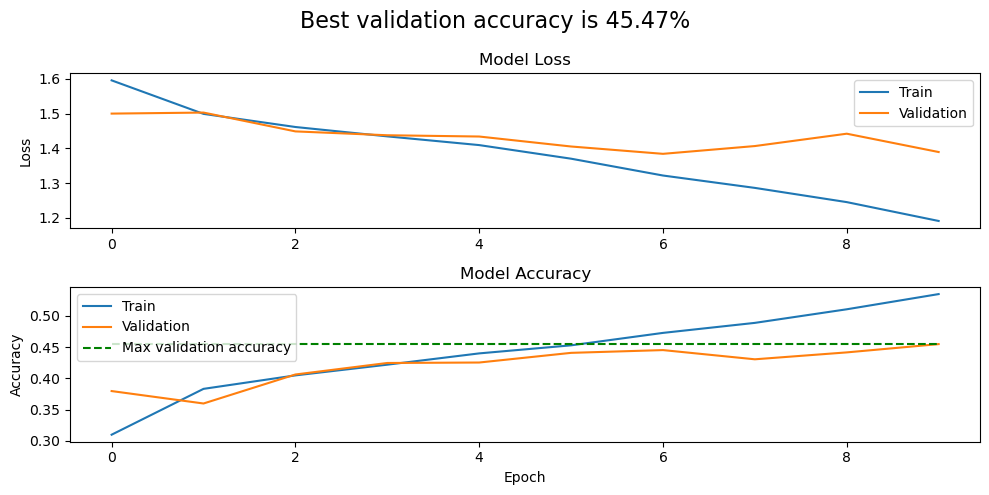

In [83]:
plot_history(history_CNN1d)

In [84]:
score, acc = CNN1d_model.evaluate(X_test_1D_CNN, y_test['y_emotion'])
print('Test accuracy is {:.2f}%'.format(100*acc))

54/54 [==============================] - 2s 40ms/step - loss: 1.3811 - accuracy: 0.4626
Test accuracy is 46.26%


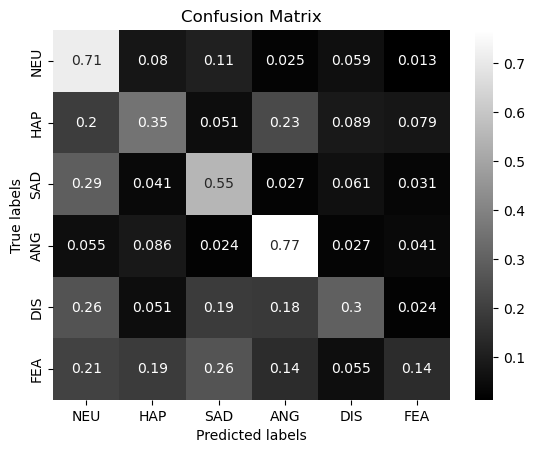

In [85]:
y_pred = CNN1d_model.predict_classes(X_test_1D_CNN)
confusion(y_test['y_emotion'],y_pred)

# (E) Appendix: 1D Convolutional Neural Network with 8kHz sample rate
- To address the possibility that the audio files with a 22kHz sample rate were providing too much information, we downsampled the audio to 8kHz and ran the models. These models performed at about the same level as the 22kKz model. This suggests that the CNN is capable of using its filters to perform any necessary downsampling.

### Load in X_train, X_test

In [86]:
# load the data
X_train_1D_8k_CNN = np.load('extracted_features_for_modeling/X_train_1D_8k_CNN.npy',allow_pickle=True)
X_test_1D_8k_CNN = np.load('extracted_features_for_modeling/X_test_1D_8k_CNN.npy',allow_pickle=True)

# Check out the data
print(f'X_train_1D_CNN shape: {X_train_1D_8k_CNN.shape}')
print(f'y_train length: {len(y_train)}')
print(f'X_test_1D_CNN shape: {X_test_1D_8k_CNN.shape}')
print(f'y_test length: {len(y_test)}')

X_train_1D_CNN shape: (6792, 16000)
y_train length: 6792
X_test_1D_CNN shape: (1699, 16000)
y_test length: 1699


### Scale the data - we do not scale the data
We do not scale since the audio data is already a single feature on the same scale

In [87]:
# range of x values
print(f'X_train_1D_8k_CNN range: {X_train_1D_8k_CNN.min()}-{X_train_1D_8k_CNN.max()}')
print(f'X_test_1D_8k_CNN range: {X_test_1D_8k_CNN.min()}-{X_test_1D_8k_CNN.max()}')

X_train_1D_8k_CNN range: -1.2306281328201294-1.2510958909988403
X_test_1D_8k_CNN range: -1.1805421113967896-1.2075802087783813


### Reshape the data

In [88]:

print('Before reshaping:')
print(f'X_train_1D_8k_CNN shape: {X_train_1D_8k_CNN.shape}')
print(f'X_test_1D_8k_CNN shape: {X_test_1D_8k_CNN.shape}\n')

# Reshape for Keras model types
X_train_1D_8k_CNN = X_train_1D_8k_CNN.reshape(X_train_1D_8k_CNN.shape[0], X_train_1D_8k_CNN.shape[1], 1)
X_test_1D_8k_CNN = X_test_1D_8k_CNN.reshape(X_test_1D_8k_CNN.shape[0], X_train_1D_8k_CNN.shape[1], 1)

print('After reshaping:')
print(f'X_train_1D_8k_CNN shape: {X_train_1D_8k_CNN.shape}')
print(f'X_test_1D_8k_CNN shape: {X_test_1D_8k_CNN.shape}')

Before reshaping:
X_train_1D_8k_CNN shape: (6792, 16000)
X_test_1D_8k_CNN shape: (1699, 16000)

After reshaping:
X_train_1D_8k_CNN shape: (6792, 16000, 1)
X_test_1D_8k_CNN shape: (1699, 16000, 1)


### 1D CNN 8kHz sr v1 - two convolutions
- First
 - kernel_size = 11
 - strides = 10
- Second
 - kernel_size = 50
 - strides = 3

#### Architecture

In [89]:
CNN1d_8k_model = Sequential()

# Create simple CNN model architecture with Pooling for dimensionality reduction 
# and Dropout to reduce overfitting
CNN1d_8k_model.add(Conv1D(30, strides=10, kernel_size=11, activation = 'relu', input_shape = (16000,1)))
CNN1d_8k_model.add(MaxPooling1D(pool_size=2))
CNN1d_8k_model.add(Dropout(0.25))

CNN1d_8k_model.add(Conv1D(30, strides=3, kernel_size=50, activation = 'relu'))
CNN1d_8k_model.add(MaxPooling1D(pool_size=2))
CNN1d_8k_model.add(Dropout(0.25))

# Flatten the output of our convolutional layers
CNN1d_8k_model.add(Flatten())

# Add dense layers
CNN1d_8k_model.add(Dense(64, activation='relu'))
CNN1d_8k_model.add(Dense(32, activation='relu'))
CNN1d_8k_model.add(Dense(6, activation='softmax'))

# Print out a summary of the network
CNN1d_8k_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_7 (Conv1D)            (None, 1599, 30)          360       
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 799, 30)           0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 799, 30)           0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 250, 30)           45030     
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 125, 30)           0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 125, 30)           0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 3750)             

#### Compile & fit

In [90]:
# Compile the model with the desired loss function, optimizer, and metric(s) to track
CNN1d_8k_model.compile(loss = 'sparse_categorical_crossentropy',
                  optimizer = 'Adam',
                  metrics = ['accuracy'])

In [91]:
%%time
history_CNN1d_8k = CNN1d_8k_model.fit(X_train_1D_8k_CNN, y_train['y_emotion'], epochs=20, verbose=1, validation_split=0.2)

Epoch 1/20


C:\Users\Stonebreaker06\Anaconda3\envs\deeplearning\lib\site-packages\tensorflow\python\keras\engine\data_adapter.py:1402: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


170/170 [==============================] - 18s 103ms/step - loss: 1.6065 - accuracy: 0.3151 - val_loss: 1.5142 - val_accuracy: 0.3451
Epoch 2/20
170/170 [==============================] - 17s 98ms/step - loss: 1.4940 - accuracy: 0.3917 - val_loss: 1.4794 - val_accuracy: 0.3981
Epoch 3/20
170/170 [==============================] - 17s 99ms/step - loss: 1.4645 - accuracy: 0.4090 - val_loss: 1.4721 - val_accuracy: 0.3988
Epoch 4/20
170/170 [==============================] - 17s 99ms/step - loss: 1.4266 - accuracy: 0.4261 - val_loss: 1.4599 - val_accuracy: 0.4040
Epoch 5/20
170/170 [==============================] - 17s 98ms/step - loss: 1.3933 - accuracy: 0.4348 - val_loss: 1.4422 - val_accuracy: 0.4202
Epoch 6/20
170/170 [==============================] - 17s 98ms/step - loss: 1.3704 - accuracy: 0.4478 - val_loss: 1.4297 - val_accuracy: 0.4246
Epoch 7/20
170/170 [==============================] - 17s 100ms/step - loss: 1.3266 - accuracy: 0.4668 - val_loss: 1.4287 - val_accuracy: 0.4312
E

#### Scores

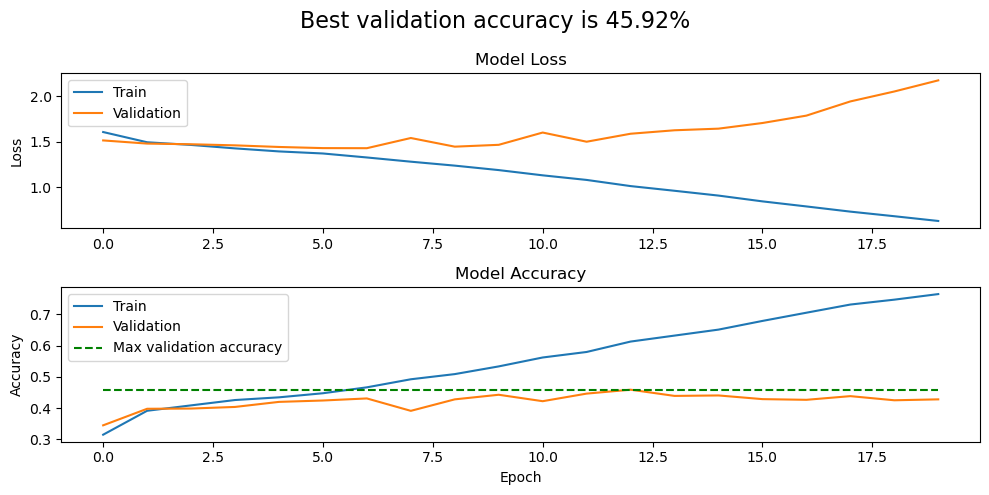

In [92]:
plot_history(history_CNN1d_8k)

In [93]:
score, acc = CNN1d_8k_model.evaluate(X_test_1D_8k_CNN, y_test['y_emotion'])
print('Test accuracy is {:.2f}%'.format(100*acc))

54/54 [==============================] - 1s 25ms/step - loss: 2.1786 - accuracy: 0.4132
Test accuracy is 41.32%


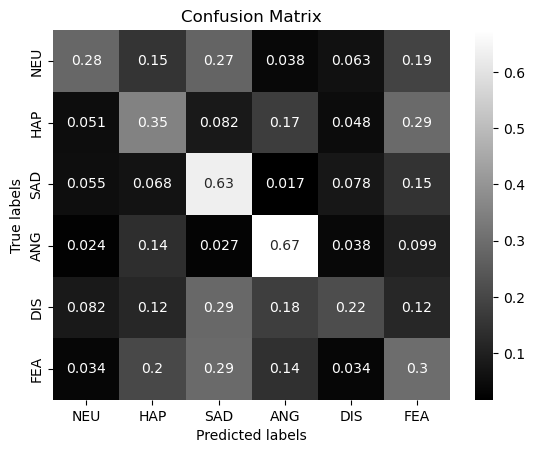

In [94]:
y_pred = CNN1d_8k_model.predict_classes(X_test_1D_8k_CNN)
confusion(y_test['y_emotion'],y_pred)

### 1D CNN 8kHz sr v2 - two convolutions
- First
 - kernel_size = 11
 - strides = 10
- Second
 - kernel_size = 50
 - strides = 3

#### Architecture

In [95]:
CNN1d_8k_model2 = Sequential()

# Create simple CNN model architecture with Pooling for dimensionality reduction 
# and Dropout to reduce overfitting
CNN1d_8k_model2.add(Conv1D(30, strides=10, kernel_size=25, activation = 'relu', input_shape = (16000,1)))
CNN1d_8k_model2.add(MaxPooling1D(pool_size=2))
CNN1d_8k_model2.add(Dropout(0.25))

CNN1d_8k_model2.add(Conv1D(30, strides=3, kernel_size=50, activation = 'relu'))
CNN1d_8k_model2.add(MaxPooling1D(pool_size=2))
CNN1d_8k_model2.add(Dropout(0.25))

# Flatten the output of our convolutional layers
CNN1d_8k_model2.add(Flatten())

# Add dense layers
CNN1d_8k_model2.add(Dense(64, activation='relu'))
CNN1d_8k_model2.add(Dense(32, activation='relu'))
CNN1d_8k_model2.add(Dense(6, activation='softmax'))

# Print out a summary of the network
CNN1d_8k_model2.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_9 (Conv1D)            (None, 1598, 30)          780       
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 799, 30)           0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 799, 30)           0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 250, 30)           45030     
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 125, 30)           0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 125, 30)           0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 3750)             

#### Compile & fit

In [96]:
# Compile the model with the desired loss function, optimizer, and metric(s) to track
CNN1d_8k_model2.compile(loss = 'sparse_categorical_crossentropy',
                  optimizer = 'Adam',
                  metrics = ['accuracy'])

In [97]:
%%time
history_CNN1d_8k2 = CNN1d_8k_model2.fit(X_train_1D_8k_CNN, y_train['y_emotion'], epochs=20, verbose=1, validation_split=0.2)

Epoch 1/20


C:\Users\Stonebreaker06\Anaconda3\envs\deeplearning\lib\site-packages\tensorflow\python\keras\engine\data_adapter.py:1402: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


170/170 [==============================] - 18s 104ms/step - loss: 1.6369 - accuracy: 0.3066 - val_loss: 1.5953 - val_accuracy: 0.3171
Epoch 2/20
170/170 [==============================] - 18s 106ms/step - loss: 1.5111 - accuracy: 0.3674 - val_loss: 1.4829 - val_accuracy: 0.3819
Epoch 3/20
170/170 [==============================] - 18s 108ms/step - loss: 1.4600 - accuracy: 0.4059 - val_loss: 1.4543 - val_accuracy: 0.3922
Epoch 4/20
170/170 [==============================] - 18s 109ms/step - loss: 1.4281 - accuracy: 0.4154 - val_loss: 1.4293 - val_accuracy: 0.4113
Epoch 5/20
170/170 [==============================] - 19s 109ms/step - loss: 1.3838 - accuracy: 0.4521 - val_loss: 1.4488 - val_accuracy: 0.4268
Epoch 6/20
170/170 [==============================] - 19s 109ms/step - loss: 1.3468 - accuracy: 0.4642 - val_loss: 1.4728 - val_accuracy: 0.4305
Epoch 7/20
170/170 [==============================] - 19s 110ms/step - loss: 1.3072 - accuracy: 0.4832 - val_loss: 1.4306 - val_accuracy: 0.4

#### Scores

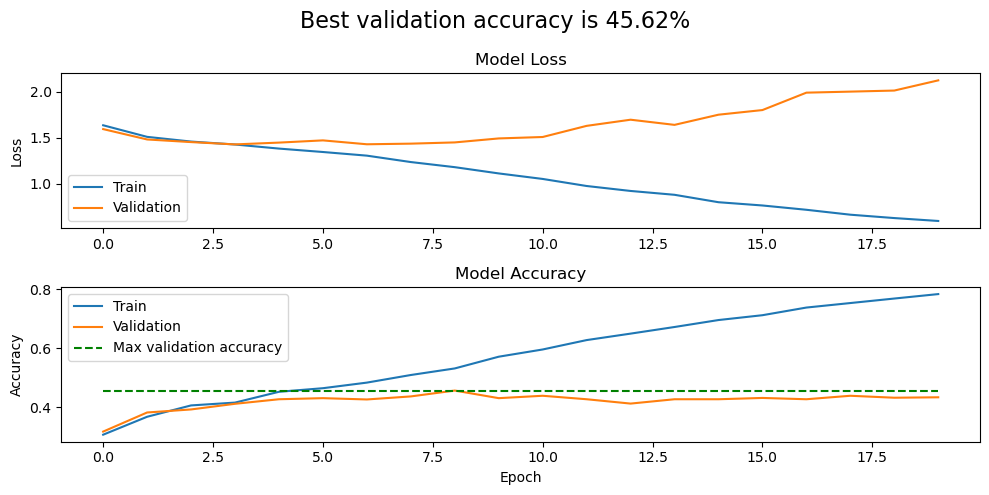

In [98]:
plot_history(history_CNN1d_8k2)

In [99]:
score, acc = CNN1d_8k_model2.evaluate(X_test_1D_8k_CNN, y_test['y_emotion'])
print('Test accuracy is {:.2f}%'.format(100*acc))

54/54 [==============================] - 1s 22ms/step - loss: 2.0951 - accuracy: 0.4326
Test accuracy is 43.26%


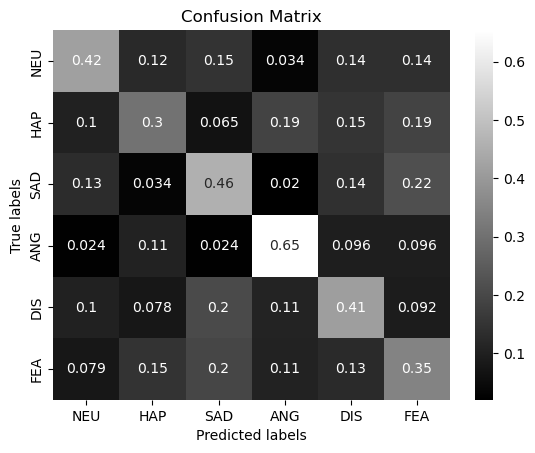

In [100]:
y_pred = CNN1d_8k_model2.predict_classes(X_test_1D_8k_CNN)
confusion(y_test['y_emotion'],y_pred)